 Loading data from: simulation_20250717_094306
 Simulation Parameters
width: 12
height: 12
densidad: 0.2
n_drones: 3
tasa_propagacion: 0.1
tasa_cura: 0.8
max_steps: 1000


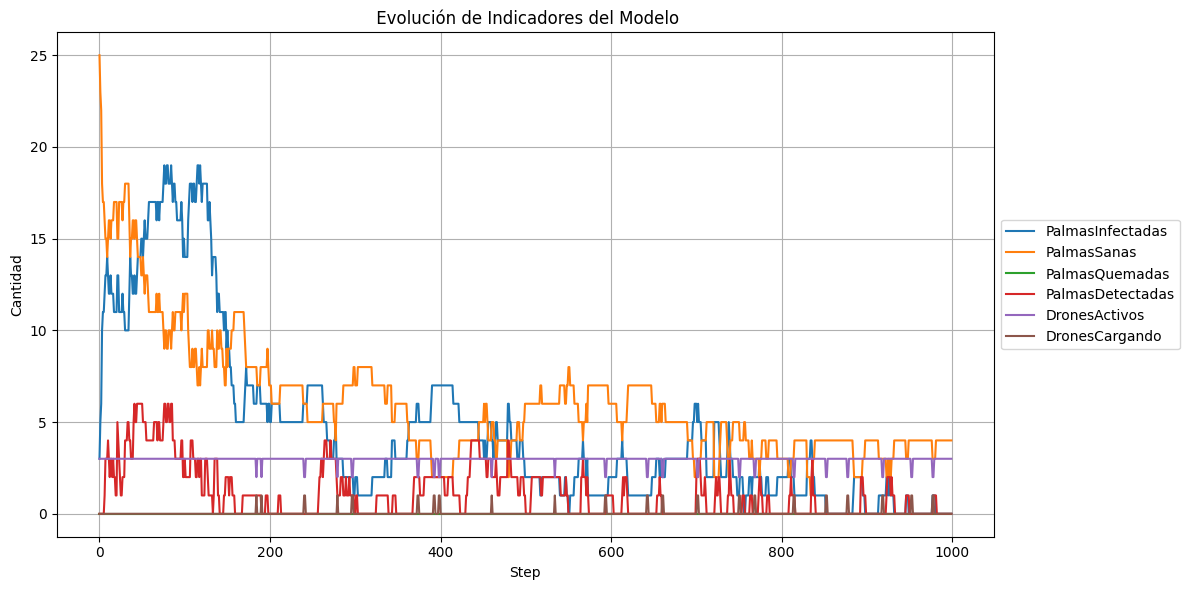


 Indicadores Finales:
PalmasInfectadas    0
PalmasSanas         4
PalmasQuemadas      0
PalmasDetectadas    0
DronesActivos       3
DronesCargando      0
Name: 999, dtype: int64


In [ ]:
# notebooks/analyze_simulation.ipynb

# --- 1. Imports ---
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
from pathlib import Path



# --- 2. Set path to latest simulation results ---
results_base = Path("../results")
latest = sorted(results_base.glob("simulation_*"))[-1]

print(f" Loading data from: {latest.name}")

model_df = pd.read_csv(latest / "model_data.csv", index_col=0)
agents_df = pd.read_csv(latest / "agents_data.csv", index_col=0)

with open(latest / "params.json") as f:
    params = json.load(f)

# --- 3. Display Parameters ---
print(" Simulation Parameters")
for k, v in params.items():
    print(f"{k}: {v}")

# --- 4. Plot Model Variables Over Time ---
indicators = [
    "PalmasInfectadas", "PalmasSanas", "PalmasQuemadas", "PalmasDetectadas",
    "DronesActivos", "DronesCargando"
]

model_df[indicators].plot(figsize=(12, 6), grid=True)
plt.title(" Evolución de Indicadores del Modelo")
plt.xlabel("Step")
plt.ylabel("Cantidad")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# --- 5. Summary Stats (Final Values) ---
summary = model_df[indicators].iloc[-1]
print("\n Indicadores Finales:")
print(summary)

# (Optional) Save summary
summary.to_csv(latest / "summary_final_indicators.csv")


In [6]:
# --- 6. Calculate Composite Performance Score ---

final = model_df.iloc[-1]

# Ensure no divide-by-zero
palmas_totales = final["PalmasTotales"] if final["PalmasTotales"] > 0 else 1
infectadas = final["PalmasInfectadas"] if final["PalmasInfectadas"] > 0 else 1

cured_rate = final["PalmasSanas"] / palmas_totales
burned_rate = final["PalmasQuemadas"] / palmas_totales
detection_rate = final["PalmasDetectadas"] / infectadas

# Weights
w1, w2, w3 = 0.4, 0.3, 0.3

# Composite score
performance_score = (
    w1 * cured_rate +
    w2 * (1 - burned_rate) +
    w3 * detection_rate
)

print("\n⭐️ Composite Performance Score:")
print(f"PerformanceScore = {performance_score:.4f}")



⭐️ Composite Performance Score:
PerformanceScore = 0.3571


/var/folders/yv/1tl1x8xx7_51dbj7560khxhm0000gn/T/ipykernel_79296/2586880996.py:35: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/jorge.mayorga/Documents/GitHub/multiagent-course-project-sim/v2/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


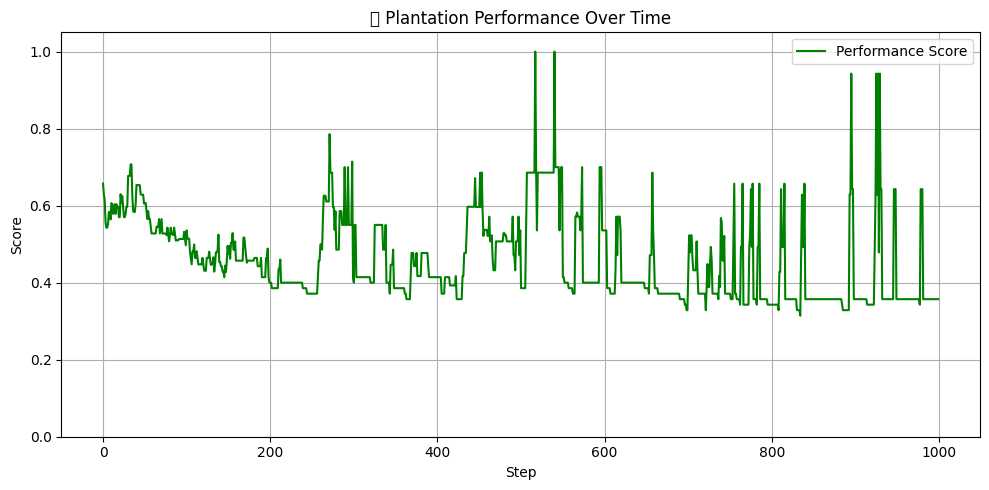

In [7]:
# --- 6. Time-Series Performance Score Calculation ---

# Defensive function for division
def safe_div(n, d):
    return n / d if d > 0 else 0

# Calculate score at each step
def compute_score(row):
    palmas_totales = row["PalmasTotales"]
    infectadas = row["PalmasInfectadas"]

    cured_rate = safe_div(row["PalmasSanas"], palmas_totales)
    burned_rate = safe_div(row["PalmasQuemadas"], palmas_totales)
    detection_rate = safe_div(row["PalmasDetectadas"], infectadas)

    w1, w2, w3 = 0.4, 0.3, 0.3

    return (
        w1 * cured_rate +
        w2 * (1 - burned_rate) +
        w3 * detection_rate
    )

# Apply to dataframe
model_df["PerformanceScore"] = model_df.apply(compute_score, axis=1)

# --- 7. Plot Performance Over Time ---
plt.figure(figsize=(10, 5))
plt.plot(model_df.index, model_df["PerformanceScore"], label="Performance Score", color="green")
plt.ylim(0, 1.05)
plt.xlabel("Step")
plt.ylabel("Score")
plt.title("🌱 Plantation Performance Over Time")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()
